# SDEの数値解法

確率微分方程式

$$dX(t) = X(2-X)dt + X dW(t)$$

を考える。ただし、$W(t)$ は標準ブラウン運動。

$X(0) = 1$ の時、この確率過程の経路を数値計算せよ。また、ノイズの無い微分方程式 $dX(t) = X(2-X)dt, X(0) = 1$ の経路と比較せよ。

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import ode
import sde
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=400)
pd.set_option('display.max_columns', 130)
pd.set_option('display.width', 800)
plt.rcParams['font.size'] = 13

# 日本語対応
mpl.rcParams['font.family'] = 'Osaka'

## 1. 理論的な話

### 1-1. 離散時間のランダムウォークから連続時間のランダムウォークを導く

時刻0に座標0にいて、その後時刻tまでにn回「確率1/2ずつで-1または1をとるベルヌーイ試行」が行われるようなランダムウォークを考える。

それぞれのベルヌーイ試行を確率変数$X_i$で表せば、

$$X_1, X_2, \ldots X_n \overset{\text{i.i.d.}}{\sim} F, \hspace{10pt} P(X=-1) = 0.5, \ P(X=1) = 0.5,\  P(X\neq-1, 1) = 0$$

となり、時刻tでの座標$S_n$は、

$$S_n = \sum X_i $$

と、$X_i$ の和で表せる。

いま $X_i$ は「X=0または1をとるベルヌーイ分布 $Ber(p=0.5)$ に従う確率変数 $B$」を $X = 2B - 1$ と変数変換して得られるので、

$$ E[X_i] = 2p - 1 = 0 \\ Var(X_i) = 2^2 p(1-p) = 1$$

となり、したがって$S_n$の平均と分散は、

$$ E[S_n] = 0 \\ Var(S_n) = n$$

となる。

ここで $X_1, \ldots X_n$ の平均 $E[X]$ は、$n \rightarrow \infty$ のときCLTから、

$$ P \left(\frac{\sqrt{n} (E[X] - \mu)}{\sigma} \leq \alpha \right) \overset{d}{\longrightarrow} N(0, 1)$$

となる。$\mu = 0,\  \sigma^2 = 1$だったので、

$$
P \left(\sqrt{n} E[X] \leq \alpha \right) \overset{d}{\longrightarrow} N(0, 1) \\
P \left( \frac{X_1 + \ldots + X_n}{\sqrt{n}} \leq \alpha \right) \overset{d}{\longrightarrow} N(0, 1) \\
$$

$t/n = \Delta t$ とおけば、

$$
P \left( \sqrt{\frac{\Delta t}{t}}(X_1 + \ldots + X_n) \leq \alpha \right) \overset{d}{\longrightarrow} N(0, 1) \\
P \left( \sqrt{\Delta t}(X_1 + \ldots + X_n) \leq \alpha \right) \overset{d}{\longrightarrow} N(0, t) \\
$$

$\Delta t$ はステップサイズに相当するので、$\Delta t \rightarrow 0$、つまりステップサイズが十分小さいとき、時刻tの座標$S_n$は平均0分散tの正規分布に従う確率変数となる。これが標準ブラウン運動。



### 1-2. 標準ブラウン運動の経路を求める（近似する）方法2つ

ブラウン運動の経路を正確に求めることは不可能だが、いくつかの標本点（時刻）をとれば、各標本点間の増分は正規分布に従うことがわかるので、折れ線で経路を近似できる。

いま時刻t=0から1まで、$\Delta t$ 間隔で $n$個の標本点を取り、標準ブラウン運動の経路を近似することを考える。この時、時刻kでの座標$S_k$の計算方法は、次の2通りが考えられる。

* 各点で$N(0,\ \Delta t)$ に従う確率変数 $X_i$ を独立に取り、$S_k = \sum^k_{i=1} X_i$ とする
* 各点で$P(X_i = -\sqrt{\Delta t}) = 0.5,\ P(X_i = \sqrt{\Delta t}) = 0.5$ に従う確率変数 $X_i$ を独立に取り、$S_k = \sum^k_{i=1} X_i$ とする

**nが十分大きいとき（つまり$\Delta t$が十分小さいとき）、両者はほぼ同じ**。なぜなら前者は正規分布の再生性から、

$$ S_n \sim N(0,\ n\Delta t) = N(0,\ 1)$$

であり、後者は1-1の最後の議論より、CLTから、

$$ P \left( \sqrt{\Delta t}(X_1 + \ldots + X_n) \leq \alpha \right) \overset{d}{\longrightarrow} N(0, 1) $$

となるため。

### 1-3. 一般の確率微分方程式の解の経路を求める（近似する）方法

$ dX(t) = A(X) dt + B(X) dW(t) $ で表現できる一階の確率微分方程式を考える。$dW(t)$は標準ブラウン運動。

1-2と同様に（あるいは通常の常微分方程式の数値解法と同様に）、細かく標本点をとって経路を計算すればよいが、この場合、各標本点でのブラウン運動の増分をベルヌーイ分布からとるケースと、正規分布からとるケースは同じとは言えないはず。

なぜなら、A(X)とB(X)に1つでもXを含む項があった場合、各時点間の増分が経路に与える影響は等価でないため。

（たぶん）このことから、正規分布から増分を取るケースでも、$\Delta t$は十分小さくとらなければならないはず。

## 2. SDEの数値計算

$$dX(t) = X(2-X)dt + X dW(t),\ X(0)=1$$

を考える。

計算法は3種類。1. Euler法（陽的） 2. 修正Euler法   3. （4段4次）ルンゲ・クッタ法。  
Wの増分の取り方は2種類。1. ベルヌーイ分布からとる  2. 正規分布からとる。  

これらについて、ステップサイズも適宜変えながら、計算をしてみる。

### 2-1. 計算法: Euler法, 増分: 正規分布 でステップサイズを適当に変えて実験

ドリフト項の無い微分方程式

$$dX(t) = X(2-X)dt,\ X(0)=1$$

と比較する。なおこの微分方程式の解析解は、$X(t) = \frac{2exp(2t)}{1 + exp(2t)}$ 。

[ODEのコード](https://github.com/myuuuuun/various/blob/master/STP/ode.py),   [SDEのコード](https://github.com/myuuuuun/various/blob/master/STP/sde.py),   [SDEにおける修正オイラー法・ルンゲクッタ法の数式的説明](http://ci.nii.ac.jp/naid/110002868791)

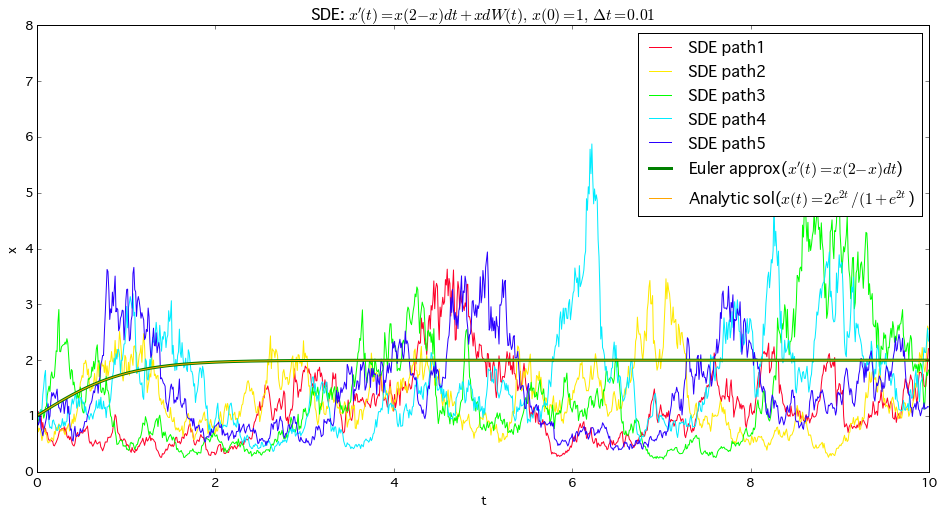

In [7]:
# settings
func = lambda x: 2*x - x**2
init = 1
t_start = 0
step = 0.01
repeat = 1000
seed = 198
ts = np.arange(t_start, step*repeat, step)
sample_size = 5


# ドリフト項の無い微分方程式の解析解の経路と、同じ方程式をEuler法で解いた時の経路
analytic_path = 2*np.exp(2*ts) / (1 + np.exp(2*ts))
approx_path = ode.euler(func, init, t_start, step, repeat)


# SDEをEuler法で解く
rs = np.random.RandomState(seed)
random_coef = lambda x: x
random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

euler_path = np.zeros((sample_size, repeat))
for i in range(sample_size):
    euler_path[i] = sde.sde_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

    
# plot
fig, ax = plt.subplots(figsize=(16, 8))
plt.title(r"SDE: $x'(t) = x(2-x) dt + x dW(t),\ x(0)=1,\ \Delta t = {0}$".format(step))
plt.xlabel("t")
plt.ylabel("x")

for i in range(sample_size):
    plt.plot(ts, euler_path[i], color=cm.gist_rainbow(i/sample_size), linewidth=1, label="SDE path{0}".format(i+1))

plt.plot(approx_path[0], approx_path[1], color='green', linewidth=3, label=r"Euler approx($x'(t) = x(2-x) dt$)")
plt.plot(ts, analytic_path, color='orange', linewidth=1, label=r"Analytic sol($x(t) = 2e^{2t} / (1+e^{2t}})$)")

plt.ylim(0, 8)
plt.legend()
plt.show()

ドリフト項の無い微分方程式と、そのEuler法による近似は一致。人口Xは2でほぼ収束。

一方で、ドリフト項入りの確率微分方程式は（期待通り）ギザギザ動いている。

次に、Euler法で100回サンプルパスを作成し、各時点での平均値をとったパスを表示してみると、

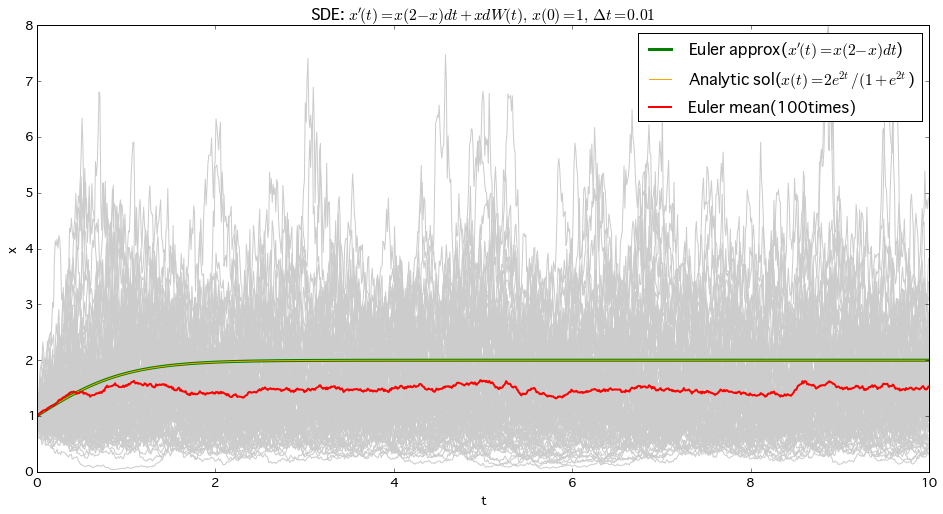

In [9]:
# settings
func = lambda x: 2*x - x**2
init = 1
t_start = 0
step = 0.01
repeat = 1000
seed = 198
ts = np.arange(t_start, step*repeat, step)
sample_size = 100


# ドリフト項の無い微分方程式の解析解の経路と、同じ方程式をEuler法で解いた時の経路
analytic_path = 2*np.exp(2*ts) / (1 + np.exp(2*ts))
approx_path = ode.euler(func, init, t_start, step, repeat)


# SDEをEuler法で解く
rs = np.random.RandomState(seed)
random_coef = lambda x: x
random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

euler_path = np.zeros((sample_size, repeat))
for i in range(sample_size):
    euler_path[i] = sde.sde_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

euler_average = np.zeros(repeat)
for i in range(repeat):
    euler_average[i] = euler_path[:, i].mean()
    
# plot
fig, ax = plt.subplots(figsize=(16, 8))
plt.title(r"SDE: $x'(t) = x(2-x) dt + x dW(t),\ x(0)=1,\ \Delta t = {0}$".format(step))
plt.xlabel("t")
plt.ylabel("x")

for i in range(sample_size):
    plt.plot(ts, euler_path[i], color="#cccccc", linewidth=1)

plt.plot(approx_path[0], approx_path[1], color='green', linewidth=3, label=r"Euler approx($x'(t) = x(2-x) dt$)")
plt.plot(ts, analytic_path, color='orange', linewidth=1, label=r"Analytic sol($x(t) = 2e^{2t} / (1+e^{2t}})$)")
plt.plot(ts, euler_average, color='red', linewidth=2, label="Euler mean({0}times)".format(sample_size))

plt.ylim(0, 8)
plt.legend()
plt.show()

1.5付近をウロウロしている。

ここで、ステップサイズを適当に変えてみると、

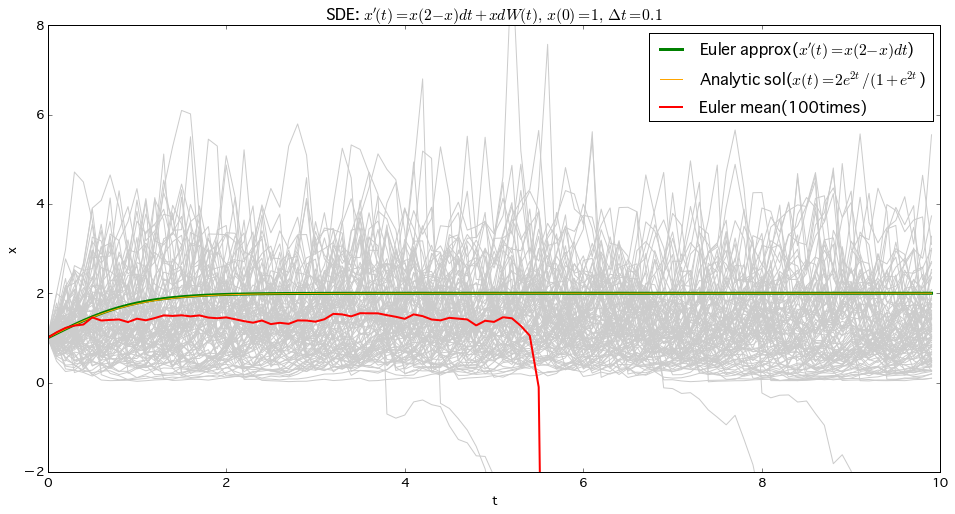

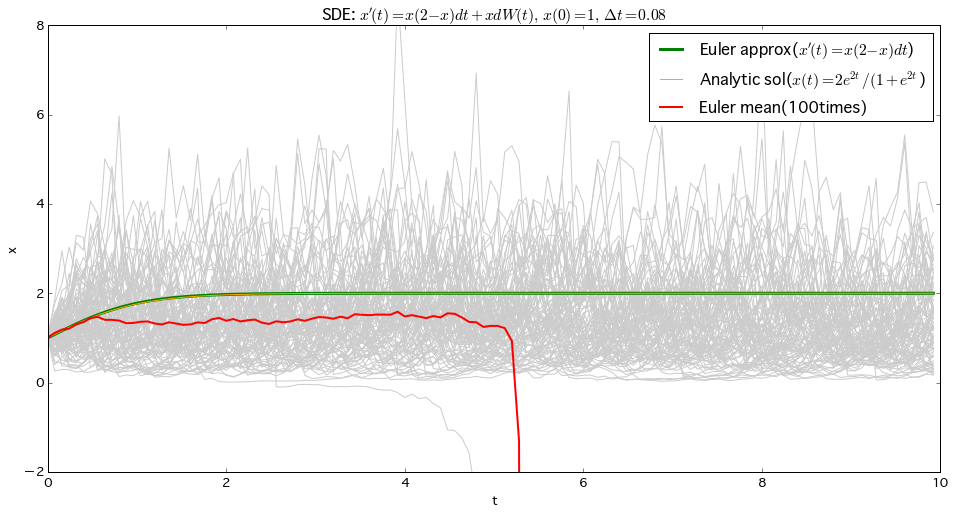

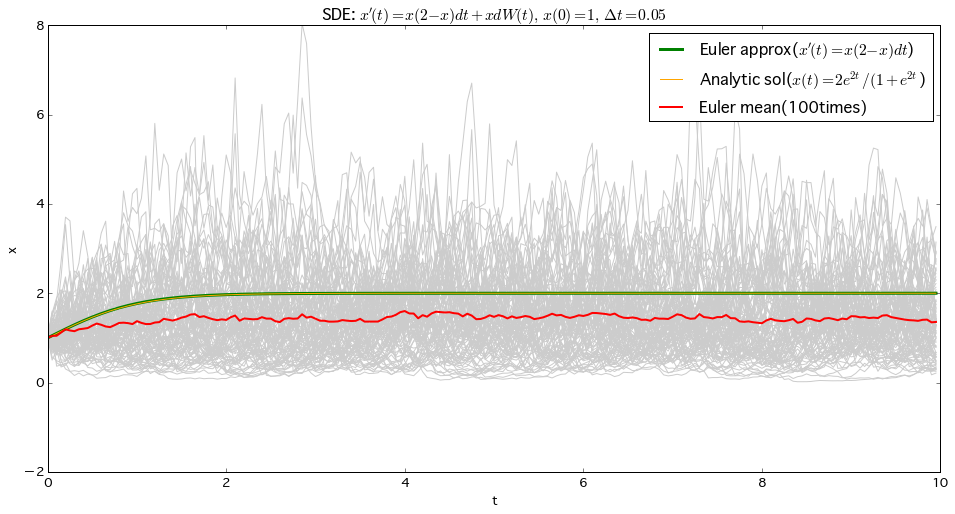

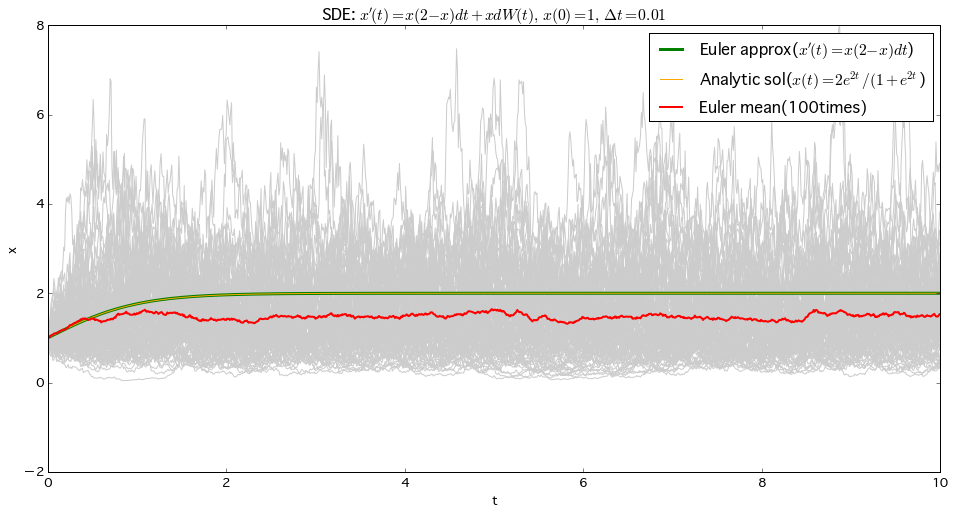

In [13]:
def plotfunc(steps):
    for s in steps:
        # settings
        func = lambda x: 2*x - x**2
        init = 1
        t_start = 0
        step = s
        repeat = int(10 / step)
        seed = 198
        ts = np.arange(t_start, step*repeat, step)
        sample_size = 100

        # ドリフト項の無い微分方程式の解析解の経路と、同じ方程式をEuler法で解いた時の経路
        analytic_path = 2*np.exp(2*ts) / (1 + np.exp(2*ts))
        approx_path = ode.euler(func, init, t_start, step, repeat)

        # SDEをEuler法で解く
        rs = np.random.RandomState(seed)
        random_coef = lambda x: x
        random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

        euler_path = np.zeros((sample_size, repeat))
        for i in range(sample_size):
            euler_path[i] = sde.sde_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

        euler_average = np.zeros(repeat)
        for i in range(repeat):
            euler_average[i] = euler_path[:, i].mean()

        # plot
        fig, ax = plt.subplots(figsize=(16, 8))
        plt.title(r"SDE: $x'(t) = x(2-x) dt + x dW(t),\ x(0)=1,\ \Delta t = {0}$".format(step))
        plt.xlabel("t")
        plt.ylabel("x")

        for i in range(sample_size):
            plt.plot(ts, euler_path[i], color="#cccccc", linewidth=1)

        plt.plot(approx_path[0], approx_path[1], color='green', linewidth=3, label=r"Euler approx($x'(t) = x(2-x) dt$)")
        plt.plot(ts, analytic_path, color='orange', linewidth=1, label=r"Analytic sol($x(t) = 2e^{2t} / (1+e^{2t}})$)")
        plt.plot(ts, euler_average, color='red', linewidth=2, label="Euler mean({0}times)".format(sample_size))

        plt.ylim(-2, 8)
        plt.legend()
        plt.show()
        
plotfunc([0.1, 0.08, 0.05, 0.01])

ステップサイズが0.08以上だと解が安定しない。なぜ？→要調査。

SDEの数値解法の線形安定性解析に関する話題: http://repository.kulib.kyoto-u.ac.jp/dspace/bitstream/2433/83687/1/0850-11.pdf

同じステップサイズであっても、ドリフト項のない通常の微分方程式の解は安定していることに注意！

### 2-2. 計算法: 3種類, 増分: 正規分布 でステップサイズを適当に変えて実験

2-1と同様、各計算法で100回ずつサンプルパスを計算、その各時点での平均を見ると、

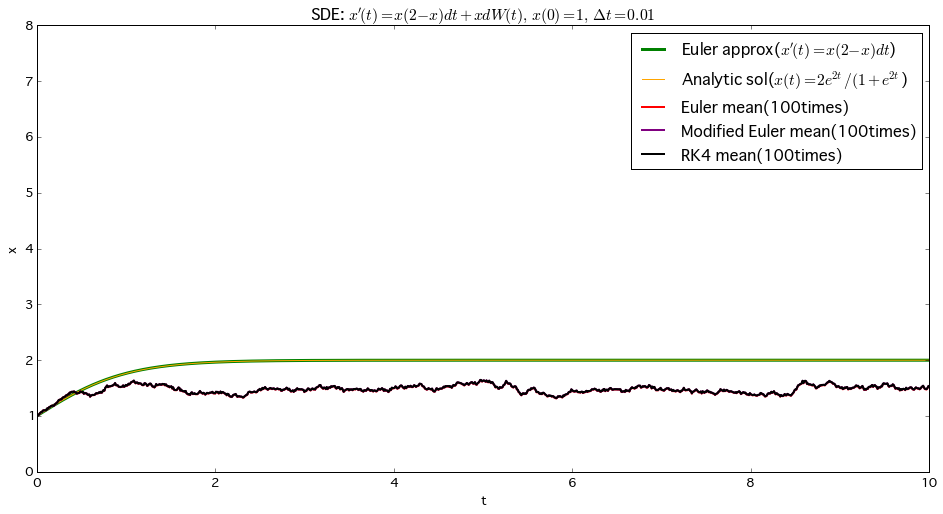

In [17]:
def plotfunc2(steps):
    for s in steps:
        func = lambda x: 2*x - x**2
        init = 1
        t_start = 0
        step = s
        repeat = int(10/s)
        seed = 198

        ts = np.arange(t_start, step*repeat, step)
        analytic_path = 2*np.exp(2*ts) / (1 + np.exp(2*ts))
        approx_path = ode.euler(func, init, t_start, step, repeat)

        sample_size = 100

        # Euler Method
        rs = np.random.RandomState(seed)
        random_coef = lambda x: x
        random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

        euler_path = np.zeros((sample_size, repeat))
        for i in range(sample_size):
            euler_path[i] = sde.sde_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

        euler_average = np.zeros(repeat)
        for i in range(repeat):
            euler_average[i] = euler_path[:, i].mean()

        # Modified Euler Method
        rs = np.random.RandomState(seed)
        random_coef = lambda x: x
        random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

        modified_euler_path = np.zeros((sample_size, repeat))
        for i in range(sample_size):
            modified_euler_path[i] = sde.sde_modified_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

        modified_euler_average = np.zeros(repeat)
        for i in range(repeat):
            modified_euler_average[i] = modified_euler_path[:, i].mean()

        # RK4 Method
        rs = np.random.RandomState(seed)
        random_coef = lambda x: x
        random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

        rk4_path = np.zeros((sample_size, repeat))
        for i in range(sample_size):
            rk4_path[i] = sde.sde_runge_kutta(func, init, t_start, step, repeat, random_coef, random_process)[1]

        rk4_average = np.zeros(repeat)
        for i in range(repeat):
            rk4_average[i] = rk4_path[:, i].mean()

        fig, ax = plt.subplots(figsize=(16, 8))
        plt.title(r"SDE: $x'(t) = x(2-x) dt + x dW(t),\ x(0)=1,\ \Delta t = {0}$".format(step))
        plt.xlabel("t")
        plt.ylabel("x")

        plt.plot(approx_path[0], approx_path[1], color='green', linewidth=3, label=r"Euler approx($x'(t) = x(2-x) dt$)")
        plt.plot(ts, analytic_path, color='orange', linewidth=1, label=r"Analytic sol($x(t) = 2e^{2t} / (1+e^{2t}})$)")
        plt.plot(ts, euler_average, color='red', linewidth=2, label="Euler mean({0}times)".format(sample_size))
        plt.plot(ts, modified_euler_average, color='purple', linewidth=2, label=r"Modified Euler mean({0}times)".format(sample_size))
        plt.plot(ts, rk4_average, color='black', linewidth=2, label=r"RK4 mean({0}times)".format(sample_size))

        plt.ylim(0, 8)
        plt.legend()
        plt.show()
        
plotfunc2([0.01])

SDEの数値解法は3種ともほぼおなじ経路をとっている＝安定している。（注: どの計算法でも、各時点でのブラウン運動の増分の実現値はおなじになるように設定している）

次に、適当にステップサイズをかえてみると、

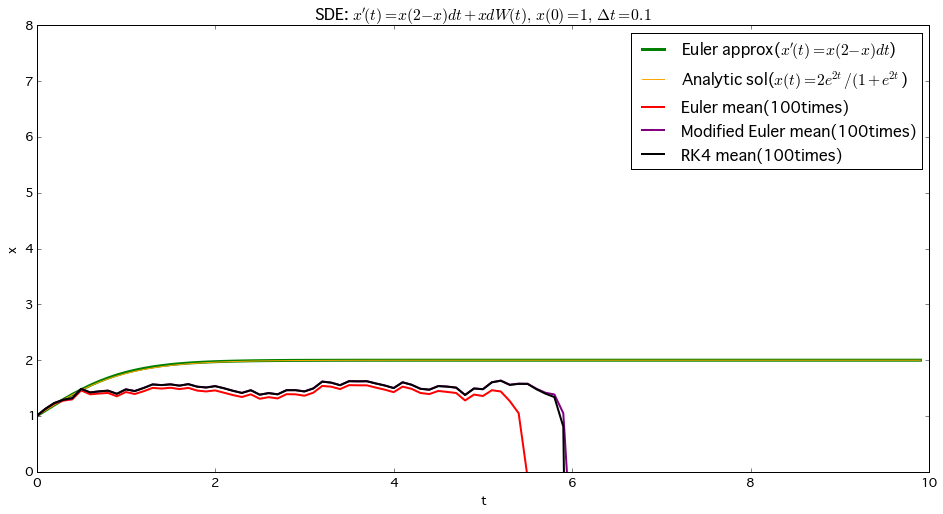

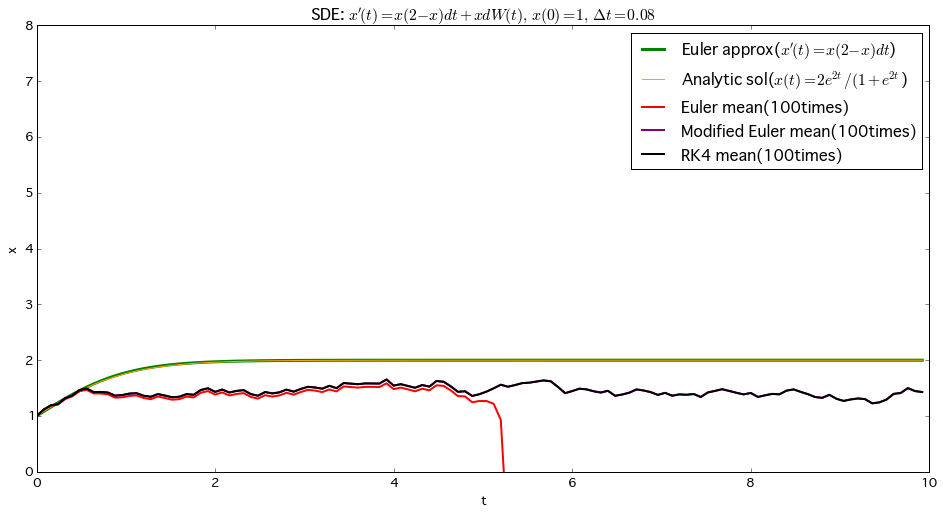

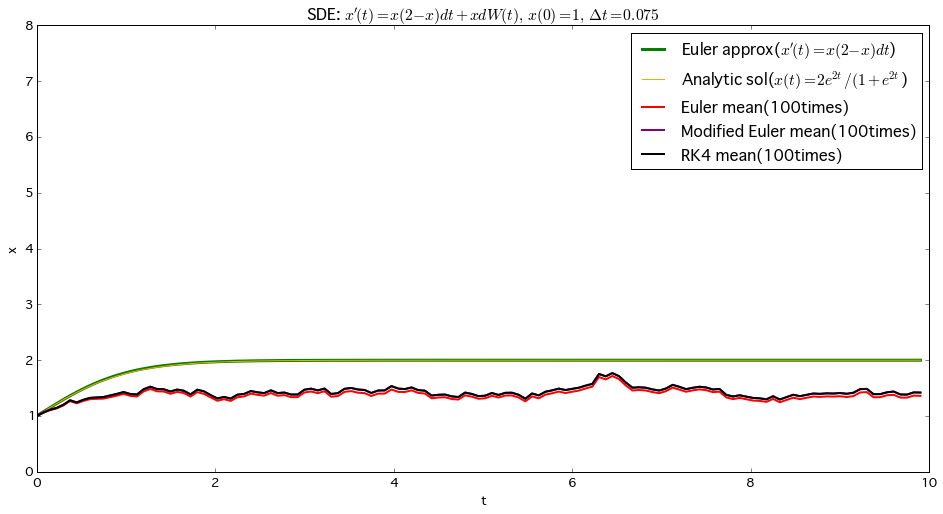

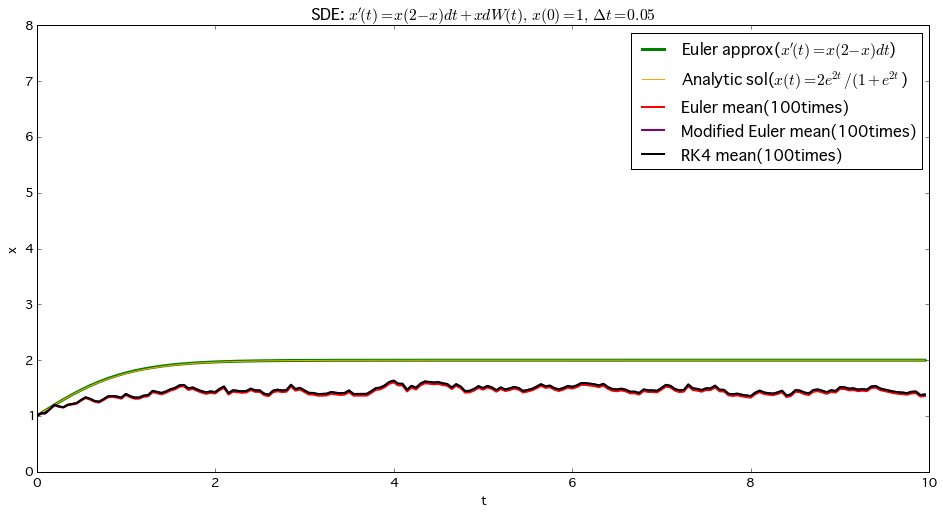

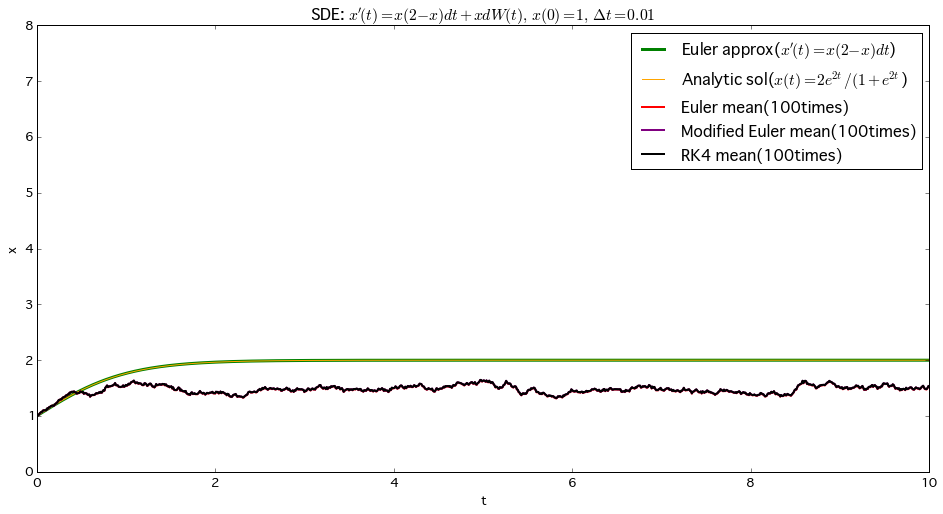

In [20]:
plotfunc2([0.1, 0.08, 0.075, 0.05, 0.01])

単純なEuler法に比べ、修正オイラー法やルンゲクッタ法の方が大きなステップサイズでも安定している。これは通常の微分方程式と同じ。

### 2-3. 計算法: Euler法で、増分がベルヌーイ分布の場合と正規分布の場合を比較

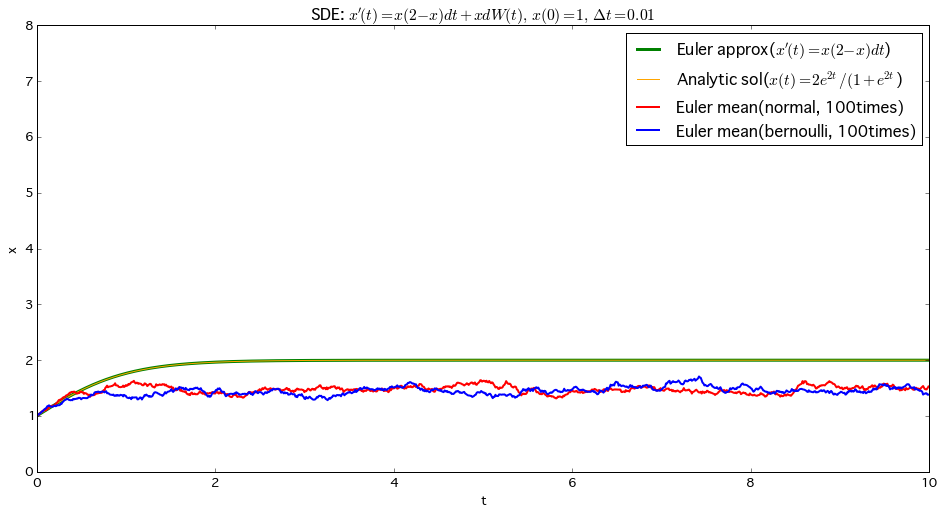

In [26]:
def plotfunc3(steps):
    for s in steps:
        func = lambda x: 2*x - x**2
        init = 1
        t_start = 0
        step = s
        repeat = int(10/step)
        seed = 198

        ts = np.arange(t_start, step*repeat, step)
        analytic_path = 2*np.exp(2*ts) / (1 + np.exp(2*ts))
        approx_path = ode.euler(func, init, t_start, step, repeat)
        sample_size = 100

        # Euler Method(normal)
        rs = np.random.RandomState(seed)
        random_coef = lambda x: x
        random_process = lambda x, step: rs.normal(loc=0, scale=math.sqrt(step))

        euler_path = np.zeros((sample_size, repeat))
        for i in range(sample_size):
            euler_path[i] = sde.sde_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

        euler_average = np.zeros(repeat)
        for i in range(repeat):
            euler_average[i] = euler_path[:, i].mean()


        # Euler Method2(bernoulli)
        rs = np.random.RandomState(seed)
        random_coef = lambda x: x
        random_process = lambda x, step: -1 * math.sqrt(step)  if rs.binomial(1, 0.5) == 0 else math.sqrt(step)

        euler_path2 = np.zeros((sample_size, repeat))
        for i in range(sample_size):
            euler_path2[i] = sde.sde_euler(func, init, t_start, step, repeat, random_coef, random_process)[1]

        euler_average2 = np.zeros(repeat)
        for i in range(repeat):
            euler_average2[i] = euler_path2[:, i].mean()

        fig, ax = plt.subplots(figsize=(16, 8))
        plt.title(r"SDE: $x'(t) = x(2-x) dt + x dW(t),\ x(0)=1,\ \Delta t = {0}$".format(step))
        plt.xlabel("t")
        plt.ylabel("x")

        plt.plot(approx_path[0], approx_path[1], color='green', linewidth=3, label=r"Euler approx($x'(t) = x(2-x) dt$)")
        plt.plot(ts, analytic_path, color='orange', linewidth=1, label=r"Analytic sol($x(t) = 2e^{2t} / (1+e^{2t}})$)")
        plt.plot(ts, euler_average, color='red', linewidth=2, label="Euler mean(normal, {0}times)".format(sample_size))
        plt.plot(ts, euler_average2, color='blue', linewidth=2, label="Euler mean(bernoulli, {0}times)".format(sample_size))

        plt.ylim(0, 8)
        plt.legend()
        plt.show()
        
plotfunc3([0.01])

だいたいおなじ……？（なぜ？）

他のステップサイズをためしてみると、

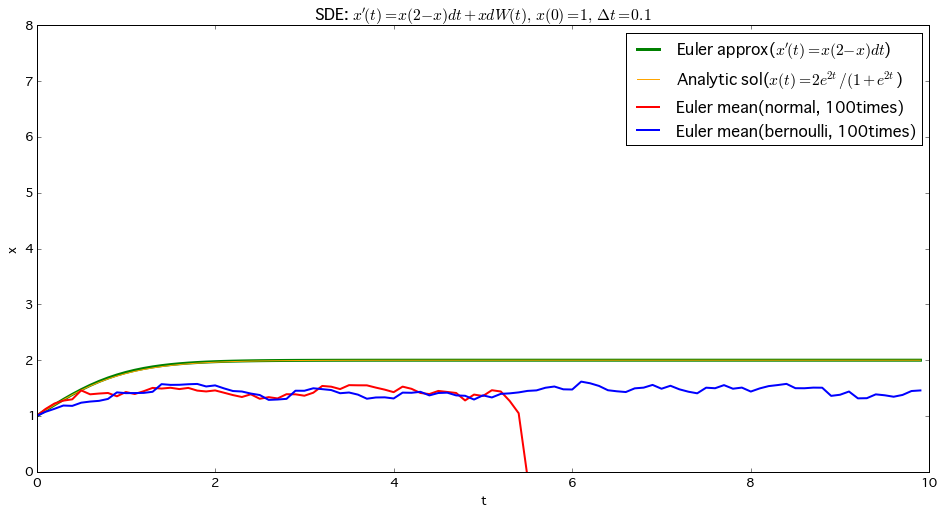

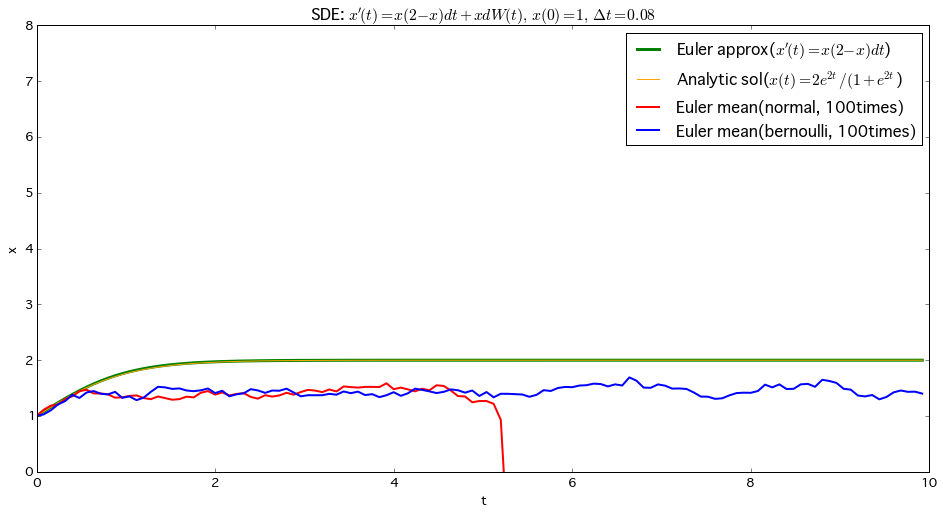

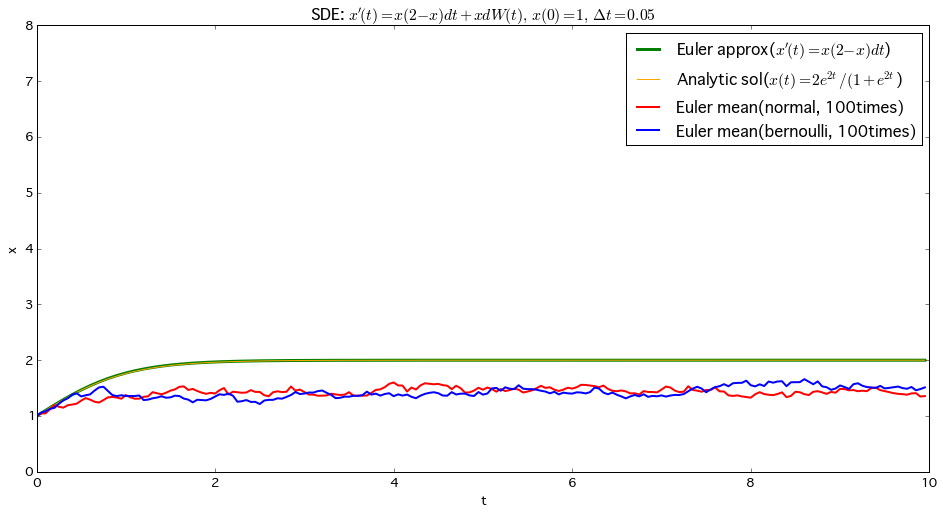

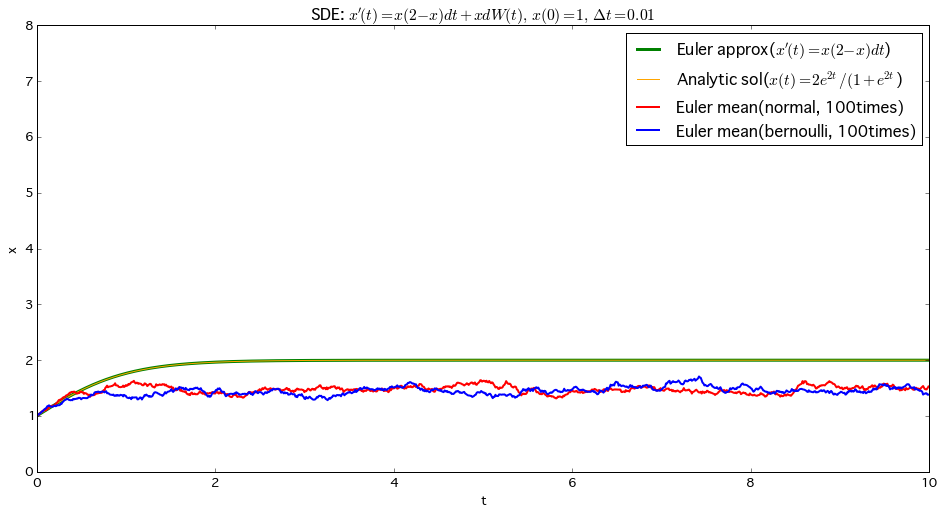

In [27]:
plotfunc3([0.1, 0.08, 0.05, 0.01])

ベルヌーイのほうが安定→これは、ベルヌーイ試行のほうが極端に小さな値が出辛いから。